<a href="https://colab.research.google.com/github/ApurvK032/Deep-Learning-CS590/blob/main/Dataset_analy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import math
import os
import glob
import matplotlib.pyplot as plt

Below there are two methods, one is maxi; it calculates the diagonal coordinates of the lessions in the mask. As different mask will have different lessions, hence all the output rectangles will of different size
hence, we are resizing all the mask to 120,120 boxes to input it to the model.  this is done bu the next method named cropped.
you can change parameters accodingly. **just a word of caution, while genertaing any kind of dataset, just make sure that every image have corresponding mask, and not any other mask. as this will lead to nad results.**

In [ ]:
import numpy as np
def maxi(img):
  img = np.array(img)
  x,y = np.where(img==1)
  x_min = min(x)
  y_min = min(y)
  x_max =max(x)
  y_max = max(y)
  return  x_min,x_max,y_min,y_max




In [ ]:
def cropped(img):
  img = np.array(img)
  x,y = np.shape(img)
  flag = 0
  # here first process is done
  x_min,x_max,y_min,y_max = maxi(img)

  for i in range(2):
    if (120-abs(x_max-x_min)) % 2 != 0:
      diff1 =   ((120-abs(x_max-x_min)) - 1) // 2
      flag = 1
    else:
      diff1 =   (120-abs(x_max-x_min)) // 2
      flag = 0

    if (120-abs(y_max-y_min)) % 2 != 0:
      diff2 =   ((120-abs(y_max-y_min)) - 1) // 2
      flag = 1
    else:
      diff2 =   (120-abs(y_max-y_min)) // 2
      flag = 0

    # here second process is done

    if x_max + diff1 > x:
      x_max = x
      x_min = x_min - flag - diff1 - abs(x_max + diff1 - x)
    else:
      x_max = x_max + diff1
      x_min = x_min - diff1 - flag

    if y_max + diff2 > y:
      y_max = y
      y_min = y_min - flag - diff2 - abs(y_max + diff2 - y)
    else:
      y_max = y_max + diff2
      y_min = y_min - diff2 - flag

  img2 = img[x_min:x_max,y_min:y_max]
  img2 = np.resize(img2,(120,120))
  img2 = np.array(img2)

  return x_min,x_max,y_min,y_max



In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the NIfTI file
img = nib.load('/content/drive/MyDrive/sub-r027s001_ses-1_space-MNI152NLin2009aSym_T1w.nii')
img1 = nib.load('/content/drive/MyDrive/lesion_reg.nii')
path = '/content/drive/MyDrive/DL_pro_dataset/12'

data1 = img.get_fdata()
data = img1.get_fdata()


# mask = []
# image = []
data2 = []
for i in range(data.shape[2]):
  if len(np.unique(data[:,:,i])) == 2:
    a,b,c,d = cropped(data[:,:,i])
    if abs(a-b) == 120 and abs(c-d) == 120:
      # mask.append(data[:,:,i][a:b,c:d])
      # image.append(data1[:,:,i][a:b,c:d])
      data2.append(tf.concat([np.expand_dims(data[:,:,i][a:b,c:d],axis = 2),np.expand_dims(data1[:,:,i][a:b,c:d],axis = 2)], axis = 2))
    else:
      a = a - (120 - abs(a-b))
      c = c - (120 - abs(c-d))
      # mask.append(np.expand_dims(data[:,:,i][a:b,c:d],axis = 2))
      # image.append(np.expand_dims(data1[:,:,i][a:b,c:d],axis = 2))
      data2.append(tf.concat([np.expand_dims(data[:,:,i][a:b,c:d],axis = 2),np.expand_dims(data1[:,:,i][a:b,c:d],axis = 2)], axis = 2))


print(len(data2))
print(data2[0].shape)
data2 = np.array(data2)
np.save(path,data2)





here we are changing the shape again to 128,128 as then we will be able to decrease the shape of the bottle neck, as doing that we can increase the accuracy of the model

In [ ]:
# here we are getting all the precomputed dataset

import os
import glob
import numpy as np


path = '/content/drive/MyDrive/DL_pro_dataset/'
temp = os.path.join(path,'*.npy')
images = glob.glob(temp)

mask = []
image = []

for img in images:
  # print(np.load(img,allow_pickle = True).shape)
  temp1  = np.load(img,allow_pickle = True)
  for i in range(len(temp1)):


    mask.append(tf.pad(temp1[i][:,:,0],([[4,4],[4,4]])))
    image.append(tf.pad(temp1[i][:,:,1],([[4,4],[4,4]])))





(128, 128)


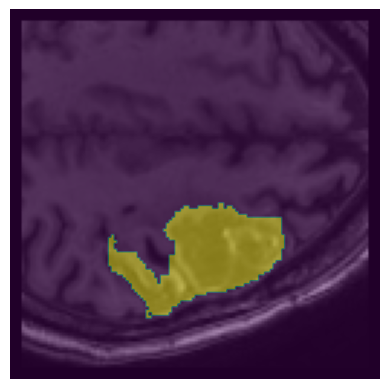

In [ ]:
plt.imshow(image[69],cmap = 'gray' )
plt.imshow(mask[69],alpha = 0.5)
plt.axis('off')
print(mask[0].shape)

572


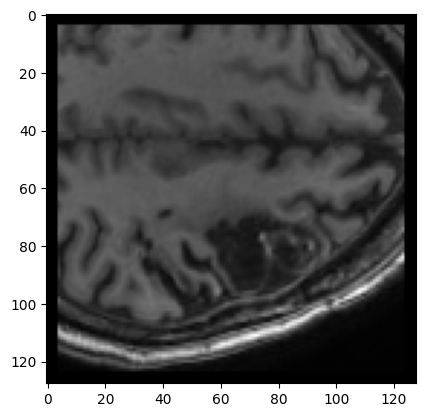

In [ ]:
plt.imshow(image[69],cmap = 'gray' )
print(len(mask))

here we are randomly choosing images to use as validation dataset. currently i an using 25, you can change to lager number, when new dataset is created

In [ ]:
# here we are taking out randomly choosen 25 images and mask for validation

mask = np.array(mask)
image = np.array(image)

mask = mask.tolist()
image = image.tolist()

r = [np.random.randint(0,571) for i in range(25)]

val_image = []
val_mask = []
train_mask = []
train_image = []

for i in range(25):
  val_image.append(image[r[i]])
  val_mask.append(mask[r[i]])
  image.pop(r[i])
  mask.pop(r[i])



here we are randomly adding noise to images to make a rhobust dataset. you must also vary intensity of images, i will help making model more rhobust

In [ ]:
# print(image_f[0].shape)
# adding noise to the images randomly

for i in range(len(image)):
  flag = np.random.uniform(0,1)
  noise = np.random.normal(0,30,(128,128))

  if flag > 0.7:
    image[i] = tf.clip_by_value(image[i] + noise,0,255)


In [ ]:
print(len(image))

547


In [ ]:
# here we are changing the classes and images to integer values

image = tf.cast(image, dtype = tf.int32)
mask = tf.cast(mask,dtype = tf.int32)
val_image = tf.cast(val_image, dtype = tf.int32)
val_mask = tf.cast(val_mask, dtype = tf.int32)

train_image = image
train_mask = mask


here are listed hyper-parameters

In [ ]:
# combination failed
# 1) [8,16,32,64,128,256]   1e-6 50 epoch
# 2) [8,16,32,64,128,256]   1e-7 30 epoch
# 3) [2,4,8,16,32,64]   1e-3 and 1e-2 20 epoch
# 4) [32,32,64,512] 1e-3 and 1e-7 30 epoch (inception layer at bottle neck)
# combination iving intermediate result
# 1)[16,16,32,32,512] 1e-6 1e-3
# 2)[64,128,256,512] 1e-5
#3) [64,128,256,512] 1e-7 1e-5 Not working(inception layer at neck)

batch_size = 1
epoch = 40
widths = [32,64,128,256,512]

image_w = 128
image_h = 128
block_depth = 2

ema = 0.999
learning_rate = 1e-7
weight_decay = 1e-4
rho = 0.9

# learning rate 1e-3,1e-6 are not working for our model, we are using 1e-5 as our learning rate. that provide us with much better result.

below is the model, Unet++. do not change any thing without asking, or complete understanding.

In [ ]:
from keras.src.layers.attention.multi_head_attention import activation

# this is the residual block of our Unet. here we perform two convolution operation and three dilated convolution with rate 3,5,7.and batchnormalizatin
def residual_block(width):
  def apply(x):
    size = x.shape[3]
    if(size == width):
      residual = x
    else:
      residual = layers.Conv2D(width, kernel_size=1)(x)

    x = layers.BatchNormalization(center = False, scale = False) (x)
    x = layers.Conv2D(width, kernel_size= 3 , padding='same',activation= 'relu')(x)
    l1 = layers.Conv2D(width, kernel_size = 3, padding='same', dilation_rate = 3,activation = 'relu')(x)
    l2 = layers.Conv2D(width, kernel_size = 3, padding = 'same', dilation_rate = 5,activation = 'relu')(x)
    l3 = layers.Conv2D(width, kernel_size = 3, padding = 'same', dilation_rate = 7,activation = 'relu')(x)
    x = layers.Conv2D(width, kernel_size= 3 , padding='same')(x)
    x = layers.Add()([x,residual,l1,l2,l3])
    return x
  return apply

# this forms decoder part of the Unet

def decoder_block(width, block_depth):
  def apply(x):
    x , skips = x
    x = layers.UpSampling2D(size = 2 , interpolation = 'bilinear')(x)

    for _ in range(block_depth):
      x = layers.Concatenate()([x,skips.pop()])
      x = residual_block(width)(x)

    return x

  return apply

# this forms encoder part of our Unet

def encoder_block(width,block_depth):
  def apply(x):
    x,skips = x

    for _ in range(block_depth):
      x = residual_block(width)(x)
      skips.append(x)

    x = layers.AveragePooling2D(pool_size = 2)(x)
    return x
  return apply


# here we are generating all the skip connection for the unet++

def skip_final(skips):
  skips_true = []
  temp = []
  skips_true.append(skips[0])
  count = 0
  while(True):
    if count%2 == 0:

      for i in range(len(skips)-1):
        if i%2 == 0:
          temp.append(layers.Concatenate()([skips[i+1],skips[i]]))
        else:
          temp.append(layers.Concatenate()([skips[i+1],layers.UpSampling2D(size = 2, interpolation = 'bilinear')(skips[i])]))
      # print(layers.Concatenate()([skips[i+1],layers.UpSampling2D(size = 2, interpolation = 'bilinear')(skips[i])]).shape)
    else:

      for i in range(len(skips)-1):
        if i%2 == 0:
          temp.append(layers.Concatenate()([skips[i+1],layers.UpSampling2D(size = 2, interpolation = 'bilinear')(skips[i])]))

        else:
          temp.append(layers.Concatenate()([skips[i+1],skips[i]]))

    count = count + 1


    skips = temp
    skips_true.append(temp[0])
    if(len(temp) == 1):
      break
    temp = []

  return skips_true


def Network(image_h,image_w, widths, block_depth):

  image = keras.Input(shape = (image_h,image_w))
  image = tf.expand_dims(image,axis = 3)

  x = layers.Conv2D(widths[0],kernel_size=1)(image)
  skips = []
  for width in widths[:-1]:
    x = encoder_block(width,block_depth)([x,skips])


  for _ in range(block_depth):
    x = residual_block(widths[-1])(x)

# here we are generating skip connections
  skips.reverse()
  skips = skip_final(skips)
  skips.reverse()

# here i am adding a new layer at the bottle neck, after finding that results depend on the filters present at the bottle neck
  x_0 = layers.Conv2D(512, kernel_size = 1, padding='same',activation = 'relu')(x)
  x_1 = layers.Conv2D(512, kernel_size = 3, padding='same',activation = 'relu')(x)
  x_2 = layers.Conv2D(512, kernel_size = 5, padding='same',activation = 'relu')(x)
  x_3 = layers.Conv2D(512, kernel_size = 7, padding='same',activation = 'relu')(x)
  x = layers.Add()([x_0,x_1,x_2,x_3,x])

# from here upsampling is starting

  for width in reversed(widths[:-1]):
    x = decoder_block(width,block_depth)([x,skips])


  x = layers.Conv2D(2,kernel_size = 3,padding = 'same' ,activation= 'softmax' )(x)
  # x = tf.argmax(x,axis = -1)


  return keras.Model(image,x,name = "residual_unet")


abc = Network(image_h,image_w,widths,block_depth)
abc.summary()


Model: "residual_unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         64        ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         64        ['conv2d[1][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['batch_normalizat

This is the model. here we are calculating gradients and doing backpropagation

In [ ]:
class image_segment(keras.Model):


  def __init__(self,image_h,image_w,widths,block_depth):
    super().__init__()

    self.normalizer = layers.Normalization()
    self.network = Network(image_h,image_w,widths,block_depth)
    self.ema_network = keras.models.clone_model(self.network)


  def compile(self,**kwargs):
    super().compile(**kwargs)
    # self.dice = dice(name = "dice_track")
    self.loss_tracker = keras.metrics.Mean(name = "t_loss")

  @property
  def metric(self):
    return [self.loss_tracker]


  def train_model(self,image,training):
    if training:
      network = self.network
    else:
      network = self.ema_network

    pred_image = network(image,training = training)
    return pred_image

# this is our training step. here we normalize our image and then pass it to the unet++ for forwward pass. then gradients are calculated. the optimizer RMSprop is used for backpropagation.

  def train_step(self,data):
    image, mask = data
    image = self.normalizer(image, training = True)

    with tf.GradientTape() as tape:
      pred_image = self.train_model(image,training = True)
      pred_image = tf.reshape(pred_image,[128,128,2])
      image_loss = self.compiled_loss(mask,pred_image)

    gradients = tape.gradient(image_loss,self.network.trainable_weights)
    self.optimizer.apply_gradients(zip(gradients,self.network.trainable_weights))

    self.loss_tracker.update_state(image_loss)
    # self.dice.update_state(pred_image,mask)

    for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
      ema_weight.assign(ema*ema_weight + (1-ema)*weight)

    return {m.name: m.result() for m in self.metrics}

# this is the validation step

  def test_step(self,data):
    image,mask = data
    image = self.normalizer(image, training = True)

    pred_image = self.train_model(image,training = False)
    pred_image = tf.reshape(pred_image,[128,128,2])

    image_loss = self.compiled_loss(mask,pred_image)

    self.loss_tracker.update_state(image_loss)

    # self.dice.update_state(pred_image,mask)
    return {m.name: m.result() for m in self.metrics}



In [ ]:
# here we convert the imput list to tensors, as input to the model is in the form of tensors and not list

train_image = tf.convert_to_tensor(train_image)
train_mask = tf.convert_to_tensor(train_mask)
val_image = tf.convert_to_tensor(val_image)
val_mask = tf.convert_to_tensor(val_mask)

print(train_mask.shape)

(547, 128, 128)


In [ ]:
# Here we are compiling and training the model. we are using sparse categoical crossentropy as loss.

from tensorflow.keras.optimizers import RMSprop

# rmsprop = RMSprop(learning_rate=1e-7, rho=0.9)
learning_rate = 1e-6
weight_decay = 1e-4
model = image_segment(image_h,image_w,widths,block_depth)

model.compile(
        optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay),
    loss="sparse_categorical_crossentropy", metrics=["accuracy"],
)

checkpoint_path = "/content/drive/MyDrive/DL_pro/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
)

# model.normalizer.adapt(train_dataset)

# run training and plot generated images periodically

# model.fit(
#     train_image,
#     train_mask,
#     epochs=epoch,
#     validation_data=(val_image, val_mask),
#     callbacks=[checkpoint_callback],
#     batch_size=batch_size,  # Set batch_size to match your dataset's batch size
# )



Below is just the testing part

In [ ]:
model.load_weights(checkpoint_path)
# 350-450


(-0.5, 127.5, 127.5, -0.5)

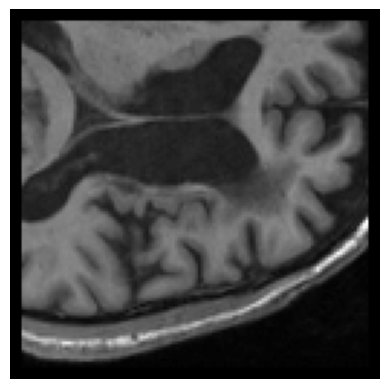

In [ ]:
img = train_image[250]
img_t = img[:]
plt.imshow(img, cmap = 'gray')
plt.axis('off')

In [ ]:
print(img.shape)
img = tf.expand_dims(img,axis = 0)
print(img.shape)


(128, 128)
(1, 128, 128)


In [ ]:
img1 = tf.expand_dims(img,axis = 3)
print(img1.shape)


(1, 128, 128, 1)


In [ ]:
pred_mask = model.train_model(image = img, training = False)
print(pred_mask.shape)

(1, 128, 128, 2)


In [ ]:
img_1 = tf.reshape(pred_mask,[128,128,2])
# img_1 = tf.cast(img_1, dtype = tf.int32)
img_f = tf.argmax(img_1, axis = 2)

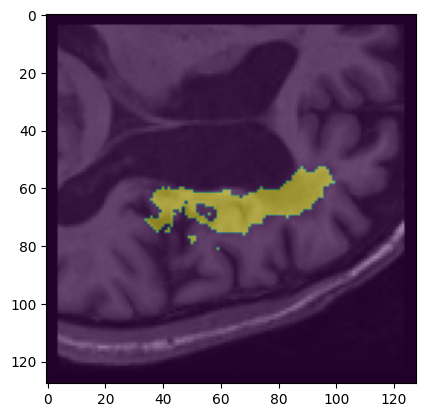

In [ ]:
plt.imshow(img_t, cmap= 'gray')
plt.imshow(img_f, alpha = 0.5)

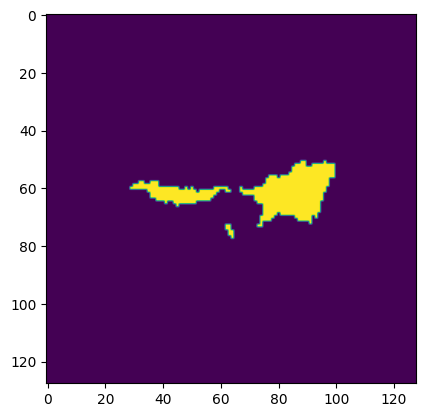

In [ ]:
plt.imshow(train_mask[250])

In [ ]:
print(65+(45/100))

65.45
